In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# import XGBRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm

In [2]:
df = pd.read_csv('hackathon_dataset_2.csv')
print("total len:", len(df))
# delete all rows in df where "SMILES" is NaN
df = df.dropna(subset=['SMILES'])
print("after dropping NA len:", len(df))
# delete duplicate SMILES
df = df.drop_duplicates(subset=['SMILES'])
print("after dropping duplicates len:", len(df))
smiles = df['SMILES']
LD50 = df['LD50']

total len: 2353
after dropping NA len: 2333
after dropping duplicates len: 2333


In [3]:
fps = []
nBits = 512
for s in smiles:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = nBits)
        vector = np.array(fp)
        fps.append(vector)
    else:
        print(s)
        fps.append(np.zeros((nBits,), dtype=int))  # Handle invalid SMILES strings
X = np.array(fps)
y = np.array(LD50)

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


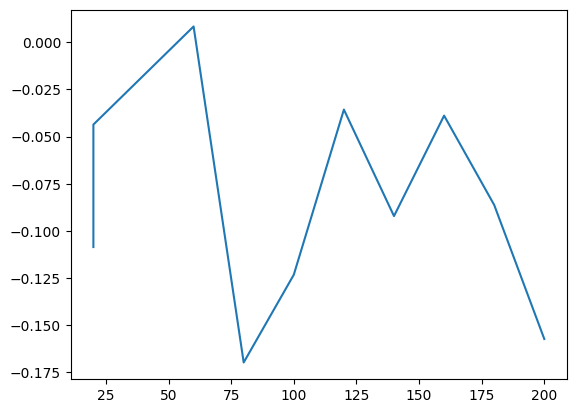

In [8]:
# PCA size param sweep
pca_num_lst = [20, 20, 60, 80, 100, 120, 140, 160, 180, 200]
r2_lst = []
for pca_num in tqdm(pca_num_lst):
    pca = PCA(n_components=pca_num)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    # RF
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_lst.append(r2)


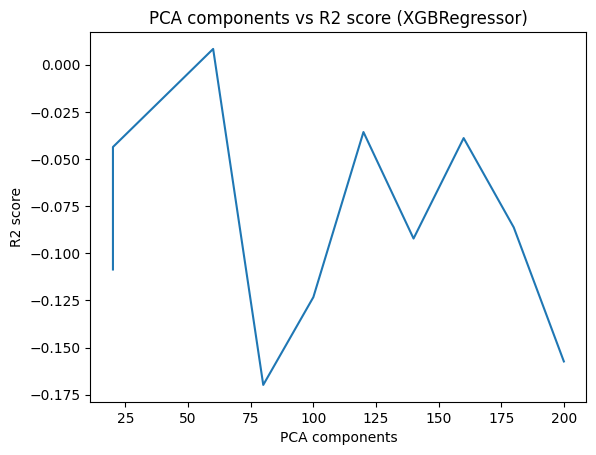

In [9]:
# plot
# x axis is pca_num_lst, y axis is r2_lst
plt.figure()
plt.xlabel("PCA components")
plt.ylabel("R2 score")
plt.title("PCA components vs R2 score (XGBRegressor)")
plt.plot(pca_num_lst, r2_lst)

In [7]:
# decisions
# model
pca_num = 25

In [5]:
# pca = PCA(n_components=pca_num)  # Reduce to 50 dimensions, for example
# X_reduced = pca.fit_transform(X)
X_reduced = X

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

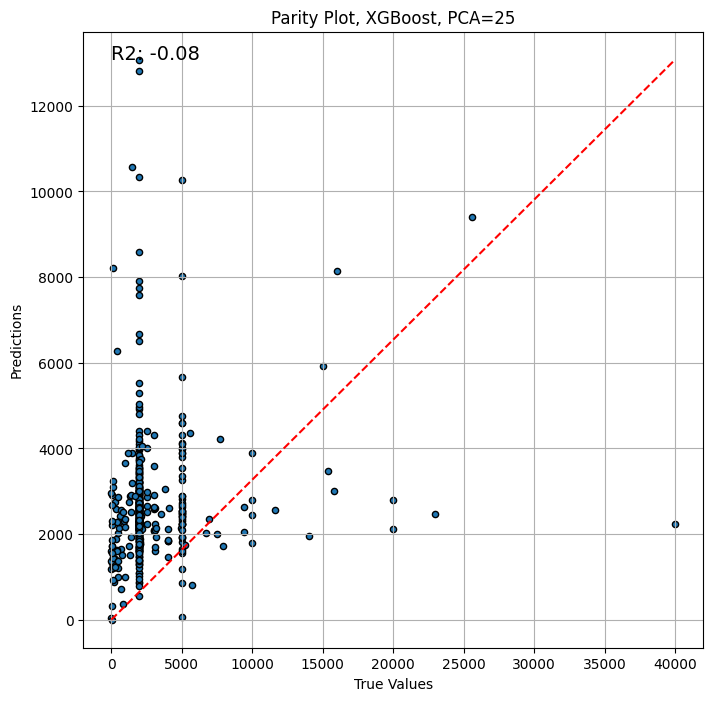

In [21]:
# Define
# RF
# model = RandomForestRegressor(n_estimators=100, random_state=42)

# GP
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# XGB
model = XGBRegressor(n_estimators=100, random_state=42)

# Fit to the data
model.fit(X_train, y_train)

# Make predictions
y_test_pred = model.predict(X_test)

# Cap predictions between min(y) and max(y)
y_test_pred = np.clip(y_test_pred, np.min(y_train), np.max(y_train))

# Parity plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, edgecolor='k', s=20)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test_pred), np.max(y_test_pred)], 'r--')
# add legend with r2
# place the text r2 in the top right corner
plt.text(np.min(y_test), np.max(y_test_pred), f'R2: {model.score(X_test, y_test):.2f}', fontsize=14)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Parity Plot, XGBoost, PCA=25')
plt.grid(True)
plt.show()


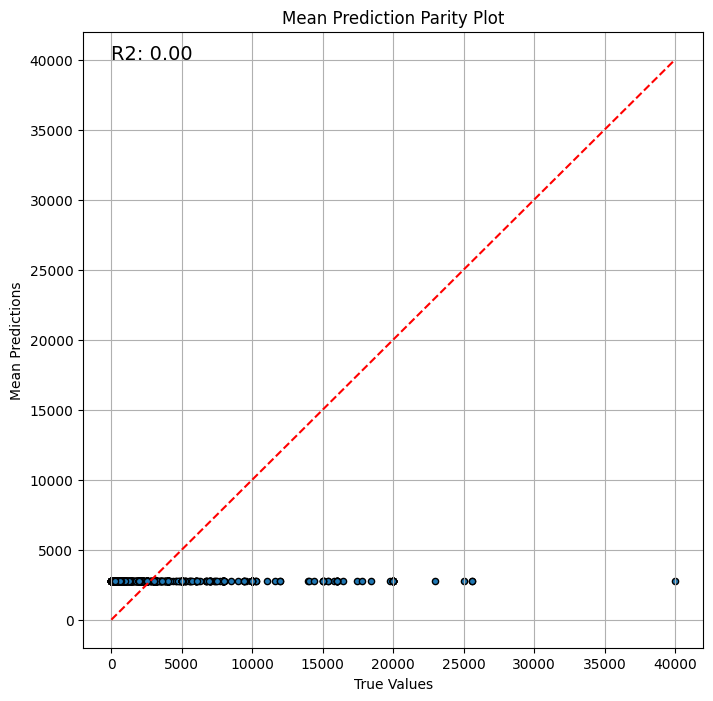

In [17]:
# Calculate the mean of the true values
y_mean = np.mean(y)

# Create an array of mean predictions with the same length as y
y_pred_mean = np.full_like(y, y_mean)

# Parity plot for mean prediction baseline
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_mean, edgecolor='k', s=20)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
# include the R2 on the plot
plt.text(min(y), max(y), f'R2: {r2_score(y, y_pred_mean):.2f}', fontsize=14)
plt.xlabel('True Values')
plt.ylabel('Mean Predictions')
plt.title('Mean Prediction Parity Plot')
plt.grid(True)
plt.show()

In [6]:
# Implement tanimoto similarity
# Function to calculate Tanimoto similarity
def calculate_tanimoto_similarity(fp1, fp2):
    """
    Calculate Tanimoto similarity between two numpy arrays representing fingerprints.
    """
    # Ensure the fingerprints are numpy arrays
    fp1 = np.asarray(fp1)
    fp2 = np.asarray(fp2)
    
    # Calculate the Tanimoto similarity
    numerator = np.dot(fp1, fp2)
    denominator = np.sum(fp1) + np.sum(fp2) - numerator
    return numerator / denominator if denominator != 0 else 0.0


# Function to predict y value using Tanimoto similarity
def predict_y(fp_query, train_fps, y_values):
    max_similarity = -1
    best_y = None
    for fp_train, y in zip(train_fps, y_values):
        if fp_train is not None:
            similarity = calculate_tanimoto_similarity(fp_query, fp_train)
            if similarity > max_similarity:
                max_similarity = similarity
                best_y = y
    return best_y

# predict y for all molecules in test set
y_test_pred = []
for i, fp_query in enumerate(X_test):
    y_pred = predict_y(fp_query, X_train, y_train)
    y_test_pred.append(y_pred)

# Cap predictions between min(y) and max(y)
y_test_pred = np.clip(y_test_pred, np.min(y_train), np.max(y_train))


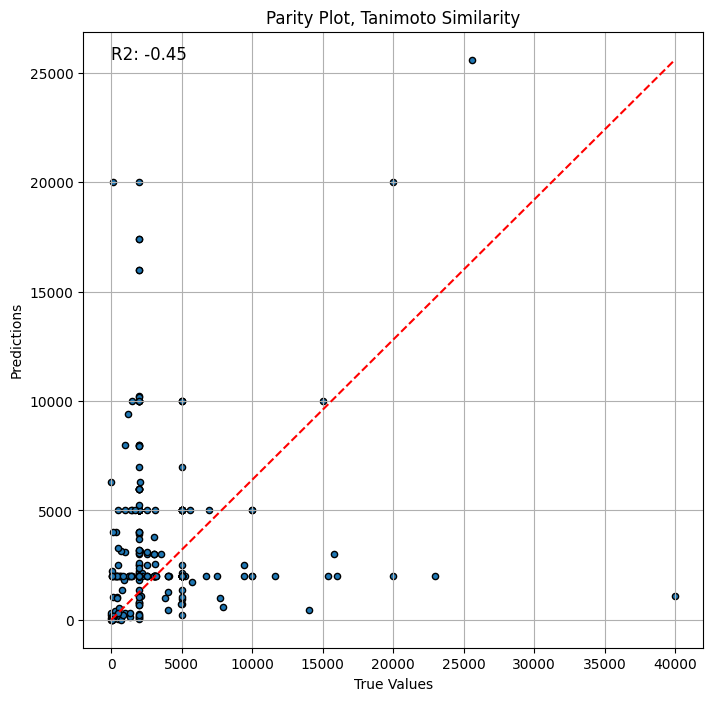

In [7]:
# Parity plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, edgecolor='k', s=20)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test_pred), np.max(y_test_pred)], 'r--')
# Calculate and add R-squared to the plot
r2 = r2_score(y_test, y_test_pred)
plt.text(np.min(y_test), np.max(y_test_pred), f'R2: {r2:.2f}', fontsize=12)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Parity Plot, Tanimoto Similarity')
plt.grid(True)
plt.show()